# Regime-Switching testing

Example taken & modified from: https://sidravi1.github.io/blog/2019/01/25/heirarchical-hidden-markov-model

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import pymc3 as pm
import theano.tensor as tt

In [3]:
import matplotlib.pyplot as plt
import arviz as az

In [4]:
import pymc3.distributions.transforms as tr

In [5]:
import warnings

warnings.simplefilter("ignore", FutureWarning)

## Set paths

In [6]:
from pathlib import Path
import regime_switching
root_path = Path(regime_switching.__root__).parent

img_path = root_path / "latex" / "img" / "gen"

# Generate samples

In [7]:
rng = np.random.default_rng(91)

In [8]:
class SampleGenerator:
    """ Generate simulated data """

    PROCESSES = ["poisson"]

    def __init__(self, process, params, n_state, transition_mat):

        if len(params) != n_state:
            raise ValueError(
                "params count: {} is not equal to n_state: {}".format(
                    len(params), n_state
                )
            )

        if (transition_mat.shape[0] != n_state) or (
            transition_mat.shape[0] != transition_mat.shape[1]
        ):
            raise ValueError("`transition_mat` is not square or not equal to `n_state`")

        if not np.isclose(transition_mat.sum(axis=1), 1).all():
            raise ValueError("`transition_mat` rows should add to 1")

        if process not in self.PROCESSES:
            raise NotImplementedError(
                "`process` type of {} is not implemented".format(process)
            )

        self.process_type = process
        self.process_params = params
        self.n_state = n_state
        self.transition_mat = transition_mat

    def __validate_inputs(self, n_samples, init_state):

        if init_state >= self.n_state:
            raise ValueError(
                "`init_state` is greater than `n_state`:{}".format(init_state)
            )

    def __getsample(self, params):

        if self.process_type == "poisson":
            sample = rng.poisson(params["lambda"])
        else:
            raise NotImplementedError("Process type not implemented")

        return sample

    def generate_samples(
        self, n_samples, seed=42, init_state=0, transition_distribution="uniform"
    ):

        self.__validate_inputs(n_samples, init_state)

        curr_state = init_state
        state_history = []
        all_samples = []

        for sample_id in range(n_samples):

            all_samples.append(self.__getsample(self.process_params[curr_state]))
            state_history.append(curr_state)

            # do i switch?
            transition_probs = self.transition_mat[curr_state]
            draw = rng.uniform()
            highs = transition_probs.cumsum()
            lows = np.roll(highs, shift=1)
            lows[0] = 0
            for i, (low, high) in enumerate(zip(lows, highs)):
                if (draw >= low) and (draw < high):
                    curr_state = i
                    break

        return np.array(all_samples), np.array(state_history)

In [9]:
_state = [0, 1]
params = xr.Dataset(
    data_vars={
        "λ": ("STATE", [5, 10]),
        "state_trans": (["STATE", "STATE_AUX"], [[0.8, 0.2], [0.2, 0.8]]),
    },
    coords={"STATE": _state, "STATE_AUX": _state,},
)


sg = SampleGenerator(
    "poisson",
    [{"lambda": params["λ"].sel(STATE=i).item()} for i in params["STATE"]],
    len(params["STATE"]),
    params["state_trans"].values,
)

vals_simple, states_orig_simple = sg.generate_samples(100)

In [10]:
df_simple = pd.DataFrame(
    {"vals": vals_simple, "states": states_orig_simple}
).reset_index()

# Define custom PyMC3 classes

In [11]:
from regime_switching.fit.chain import MarkovStateTransitions
from regime_switching.utils.pymc.fix_data import IntData

In [12]:
class PoissionProcess(pm.Discrete):
    def __init__(self, state=None, lambdas=None, *args, **kwargs):

        super(PoissionProcess, self).__init__(*args, **kwargs)

        self.state = state
        self.lambdas = lambdas

        # Housekeeping
        self.mode = tt.cast(1, dtype="int64")

    def logp(self, x):

        lambd = self.lambdas[self.state]
        llike = pm.Poisson.dist(lambd).logp_sum(x)

        return llike
    

    def random(self, point=None, size=None):
        """Random sample, used in `pm.sample_posterior_predictive()`."""
        a_state, a_lambd = pm.distributions.draw_values(
            [
                self.state,
                self.lambdas,
            ],
            point=point,
            size=size,
        )
        eff_lambd = a_lambd[a_state]
        # TODO: What to do about size?
        res = np.random.poisson(lam=eff_lambd[: np.newaxis])
        return res

# PyMC3 Model

In [13]:
_state = [1, 2]
_obs = list(range(100))
dims={
        "states": ["OBS"],
        "output": ["OBS"],
        "λ": ["STATE"],
        "init_probs": ["STATE"],
        "state_trans": ["STATE", "AUX_STATE"],
    }
coords = {"STATE": _state, "AUX_STATE": _state}


## Define

In [14]:
chain_tran = tr.Chain([tr.ordered])

with pm.Model() as m:
    IntData('observed', vals_simple)

    lambdas = pm.Gamma(
        "λ",
        mu=10,
        sd=100,
        shape=2,
        transform=chain_tran,
        testval=np.asarray([1.0, 1.5]),
    )

    init_probs = pm.Dirichlet("init_probs", a=tt.ones(2), shape=2)
    state_trans = pm.Dirichlet("state_trans", a=tt.ones(2), shape=(2, 2))

    states = MarkovStateTransitions("states", state_trans, init_probs, shape=len(vals_simple))

    y = PoissionProcess("output", states, lambdas, observed=m['observed'])

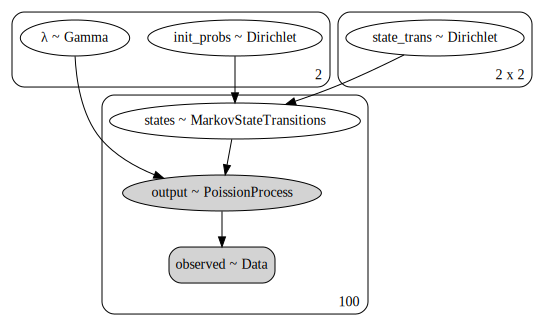

In [15]:
model_graph = pm.model_to_graphviz(m)

model_graph.render(img_path / "pp_ms_pois_graph", format="png", cleanup=True)

display(model_graph)

## Fit

In [16]:
with m:
    trace = pm.sample(draws=1000, tune=2000, chains=2, cores=2, random_seed=101)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [state_trans, init_probs, λ]
>BinaryGibbsMetropolis: [states]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [01:33<00:00, 64.40draws/s]
The number of effective samples is smaller than 25% for some parameters.


Posterior predictions works because PoissonProcess now defines `random()`; PyMC3 sampling just takes the sample values from `states` though, since there is no `random()` method there.

In [17]:
with m:
    ppc = pm.sample_posterior_predictive(trace)

100%|██████████| 2000/2000 [00:30<00:00, 65.58it/s]


In [18]:
ifd = az.from_pymc3(
    trace=trace,
    posterior_predictive=ppc,
    dims=dims,
    coords=coords,
)
ifd

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

## Check traces

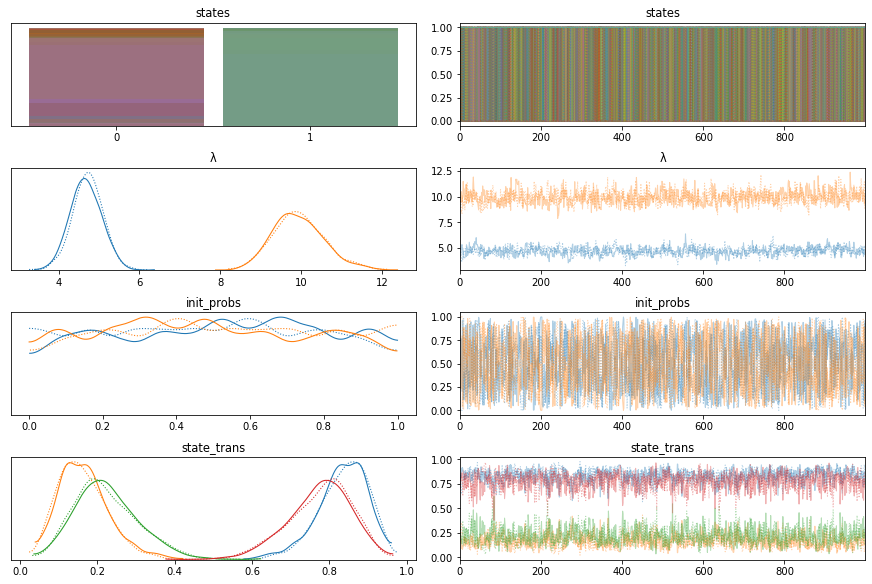

In [19]:
axs = az.plot_trace(ifd, compact=True)
fig = axs[0, 0].figure

# fig.tight_layout()
fig.savefig(img_path / "pp_ms_pois_trace.png");

# Model testing

## Posterior values

Lambda

In [20]:
params["λ"].values

array([ 5, 10])

In [21]:
ifd.posterior["λ"].mean(dim=["chain", "draw"]).values

array([4.7027344 , 9.94290353])

State transition

In [22]:
params["state_trans"].values

array([[0.8, 0.2],
       [0.2, 0.8]])

In [23]:
ifd.posterior["state_trans"].mean(dim=["chain", "draw"]).values

array([[0.83487606, 0.16512394],
       [0.22519432, 0.77480568]])

## Posterior predictive check

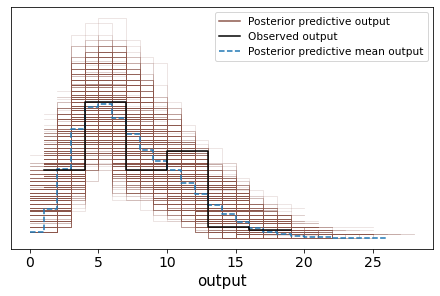

In [24]:
ax, = az.plot_ppc(ifd)
fig = ax.figure

fig.savefig(img_path / "pp_ms_pois_ppc.png");

## Model fit

In [25]:
# HDI doesn't work
# az.hdi(ifd.posterior['states'], hdi_prob=0.5)  # .set_index(hdi=['lower', 'upper'])

In [26]:
out_hdi = az.hdi(ifd.posterior_predictive['output'], hdi_prob=0.95)['output']
out_hdi['hdi']=['lower', 'upper']

In [27]:
out_hdi

<xarray.DataArray 'output' (OBS: 100, hdi: 2)>
array([[ 1., 14.],
       [ 0., 12.],
       [ 0., 11.],
       [ 0., 11.],
       [ 1., 13.],
       [ 1., 13.],
       [ 0.,  9.],
       [ 0.,  9.],
       [ 1.,  9.],
       [ 2., 15.],
       [ 4., 16.],
       [ 3., 15.],
       [ 3., 16.],
       [ 4., 16.],
       [ 3., 16.],
       [ 1., 15.],
       [ 4., 16.],
       [ 4., 16.],
       [ 4., 16.],
       [ 2., 15.],
       [ 1., 15.],
       [ 1., 12.],
       [ 1., 10.],
       [ 1., 10.],
       [ 0.,  9.],
       [ 1., 10.],
       [ 1., 14.],
       [ 1., 15.],
       [ 4., 16.],
       [ 4., 16.],
       [ 1., 14.],
       [ 0., 10.],
       [ 1.,  9.],
       [ 1., 10.],
       [ 2., 15.],
       [ 4., 16.],
       [ 4., 16.],
       [ 4., 16.],
       [ 4., 16.],
       [ 4., 16.],
       [ 3., 15.],
       [ 4., 16.],
       [ 4., 16.],
       [ 1., 12.],
       [ 0., 10.],
       [ 1., 10.],
       [ 0.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1., 14.],
       [ 1., 15.],
       [ 0., 13.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 0.,  9.],
       [ 1.,  9.],
       [ 1., 11.],
       [ 1., 10.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1., 15.],
       [ 4., 16.],
       [ 4., 16.],
       [ 2., 15.],
       [ 2., 15.],
       [ 2., 15.],
       [ 0., 10.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 0.,  9.],
       [ 1., 10.],
       [ 1., 14.],
       [ 0., 13.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 1.,  9.],
       [ 0., 10.],
       [ 0., 14.],
       [ 1., 10.],
       [ 0.,  9.],
       [ 1.,  9.],
       [ 0., 11.],
       [ 0., 10.],
       [ 2., 15.],
       [ 2., 15.],
       [ 4., 16.],
       [ 1., 15.],
       [ 3., 16.],
       [ 4., 16.]])
Coordinates:
  * OBS      (OBS) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * hdi      (hdi) <U5 'lower' 'upper'

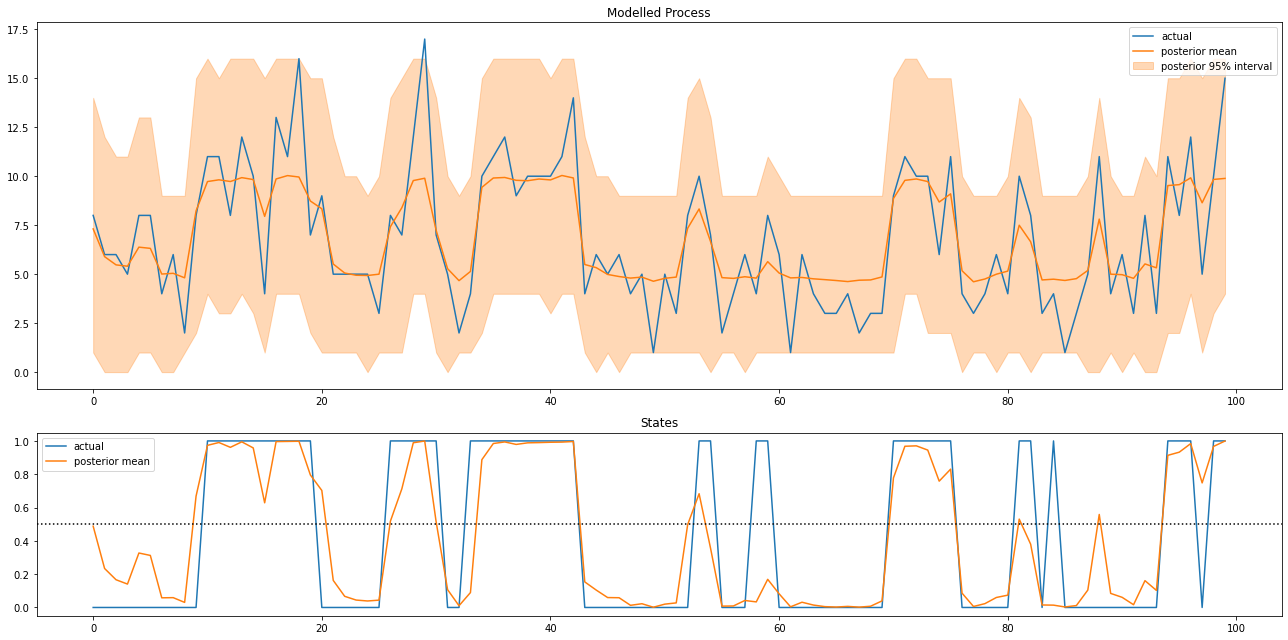

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(18, 9), gridspec_kw={"height_ratios": [2, 1]})

#
df_simple["vals"].plot.line(ax=ax[0], color="C0", label="actual")
# TODO: Get range for process
ax[0].plot(
    ifd.posterior_predictive["output"].mean(dim=["chain", "draw"]).values,
    color="C1",
    label="posterior mean",
)
ax[0].fill_between(
    out_hdi["OBS"],
    out_hdi.sel(hdi="lower").values,
    out_hdi.sel(hdi="upper").values,
    color="C1",
    alpha=0.3,
    label="posterior 95% interval",
)
ax[0].set_title("Modelled Process")
ax[0].legend()

(df_simple["states"]).plot.line(ax=ax[1], color="C0", label="actual")
ax[1].plot(
    ifd.posterior["states"].mean(dim=["chain", "draw"]).values,
    color="C1",
    label="posterior mean",
)
ax[1].axhline(0.5, color="black", linestyle=":")
ax[1].set_title("States")
ax[1].legend()

fig.tight_layout()
fig.savefig(img_path / "pp_ms_pois_fit.png");